In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [5]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
from timeit import default_timer as timer

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

TRAIN=True
HYPERPARAM_TUNING=False

In [1]:
# testing code ignore
from sklearn.utils import resample
import numpy as np
X = np.array([1, 2, 3, 5, 7, 10])
print(resample(X, n_samples=20))

[ 1  7  1  5  1  3  5 10  1  5  1  1  7  7 10  5  3 10 10  5]


### Feature list

- holiday: categorical, 0 -> no holiday, 1 -> national, 2 -> regional, 3 -> local
- onpromotion: numerical
- store_nbr: categorical, 1 to 54
- family: categorical, 1 to 33
- year: categorical ordinal, 2013 to 2017
- month: categorical ordinal, 1 to 12
- day_of_month: categorical ordinal, 1 to 31
- day_of_week: categorical ordinal, monday to sunday
- oil_price: numerical
- city: categorical, 1 to 22
- state: categorical, 1 to 16
- type: categorical, 1 to 5
- cluster: categorical, 1 to 17

In [ ]:
final_features=['store_nbr', 'family', 'onpromotion', 'year', 'month', 'day_of_month', 'day_of_week', 'oil_price', 'city', 'state', 'type', 'cluster', 'holiday']
cat_features = ['store_nbr', 'family', 'year', 'month', 'day_of_month', 'day_of_week', 'city', 'state', 'type', 'cluster', 'holiday']

In [ ]:
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
# test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
# stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
# holiday_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
# oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')

df.head(10)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

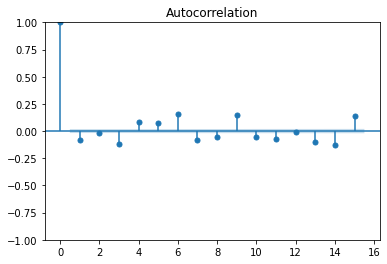

In [25]:
plot_acf(df.loc[(df['store_nbr'] == 1) & (df['year'] == 2014), 'sales'].values, lags=15)
plt.show()

In [ ]:
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
# df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
# df['day_of_week'] = df['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').weekday())
# df['day_of_month'] = df['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').day)

# test_df['year'] = test_df['date'].apply(lambda x: int(x.split('-')[0]))
# test_df['month'] = test_df['date'].apply(lambda x: int(x.split('-')[1]))
# test_df['day_of_week'] = test_df['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').weekday())
# test_df['day_of_month'] = test_df['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d').day)

df[['year', 'month', 'day_of_week', 'day_of_month', 'sales']].head(10)

In [ ]:
# Merge holiday col

df['holiday'] = [0] * df.shape[0]
test_df['holiday'] = [0] * test_df.shape[0]

holiday_type = { "National": 1, "Regional": 2, "Local": 3}

for idx, row in holiday_df.iterrows():
    if row['type'] in ['Event', 'Transfer', 'Bridge', 'Additional'] or (row['type'] == 'Holiday' and row['transferred'] == False):
        df.loc[df['date'] == row['date'], 'holiday'] = holiday_type[row['locale']]
        test_df.loc[df['date'] == row['date'], 'holiday'] = holiday_type[row['locale']]
    else:
        df.loc[df['date'] == row['date'], 'holiday'] = 0 # no holiday
        test_df.loc[df['date'] == row['date'], 'holiday'] = 0 # no holiday
        
df[['date','holiday', 'sales']].head(10)

In [ ]:
# Merge oil price col

# remove NaN values
oil_df.loc[0, 'dcoilwtico'] = oil_df.loc[1, 'dcoilwtico']
prev_row_value = None
for idx, row in oil_df.iterrows():
    if math.isnan(row['dcoilwtico']):
        oil_df.loc[idx, 'dcoilwtico'] = prev_row_value
    else:
        prev_row_value = row['dcoilwtico']
        
df = pd.merge(df, oil_df, how='left', left_on=['date'], right_on = ['date'])
df.rename(columns = {'dcoilwtico':'oil_price'}, inplace = True)
df['oil_price'] = df['oil_price'].fillna(method="ffill")

# test dataset
test_df = pd.merge(test_df, oil_df, how='left', left_on=['date'], right_on = ['date'])
test_df.rename(columns = {'dcoilwtico':'oil_price'}, inplace = True)
test_df['oil_price'] = test_df['oil_price'].fillna(method="ffill")

df[['date', 'oil_price', 'sales']].head(10)

In [ ]:
# Merge stores cols

df = pd.merge(df, stores_df, how='left', left_on=['store_nbr'], right_on = ['store_nbr'])
test_df = pd.merge(test_df, stores_df, how='left', left_on=['store_nbr'], right_on = ['store_nbr'])

df[['store_nbr', 'city', 'state', 'type', 'cluster']].head(10)

## Training

In [ ]:
# Feature Encoding & Scaling

cat_encoder = OrdinalEncoder()
df[cat_features] = cat_encoder.fit_transform(df[cat_features])

# test dataset
test_df[cat_features] = cat_encoder.transform(test_df[cat_features])

In [ ]:
X = df[final_features]
y = df['sales']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Sample row after scaling:")
print(np.round(X_scaled[0], 4).tolist())

# test dataset
X_test = test_df[final_features]
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled,
    y,
    test_size=0.3,
    random_state=42,
)

print("Train dataset size:", X_train.shape)
print("Test dataset size:", X_val.shape)

In [ ]:
if TRAIN:
#     model = xgb.XGBRegressor(n_estimators=800, max_depth=11, learning_rate=0.35, booster='gbtree', random_state=42, n_jobs=-1, verbosity=2, tree_method="gpu_hist")
    model = RandomForestRegressor(max_depth=20, max_features=8, n_estimators=55, random_state=42, n_jobs=-1)
    start_time = timer()
    model.fit(X_train, y_train)
    print('Training time: ', timer() - start_time)
    
    print("Train accuracy:", round(model.score(X_train, y_train), 4))
    print("Test accuracy:", round(model.score(X_val, y_val), 4))

    y_pred = model.predict(X_val)
    y_pred = [yp if yp > 0 else 0 for yp in y_pred]
    rms_error = mean_squared_log_error(y_val, y_pred, squared=False)

    print("Mean Squared Log Error:", round(rms_error, 5))

In [ ]:
# Get sample of dataset

if HYPERPARAM_TUNING:

    df_sample = df.sample(n=100000)

    X_sample = df_sample[final_features]
    y_sample = df_sample['sales']

    X_scaled_sample = scaler.transform(X_sample)

    print("Sample row after scaling:")
    print(np.round(X_scaled_sample[0], 4).tolist())

    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
        X_scaled_sample,
        y_sample,
        test_size=0.3,
        random_state=42,
    )

    print("Train dataset size:", X_train_sample.shape)
    print("Test dataset size:", X_test_sample.shape)

In [ ]:
if HYPERPARAM_TUNING:
    def get_rmse_error(kwargs):
    #     rfm = xgb.XGBRegressor(random_state=42, n_jobs=-1, **kwargs)
        rfm = RandomForestRegressor(random_state=42, n_jobs=-1, **kwargs)
        rfm.fit(X_train_sample, y_train_sample)

        train_rmse = mean_squared_error(rfm.predict(X_train_sample), y_train_sample, squared=False)
        test_rmse = mean_squared_error(rfm.predict(X_test_sample), y_test_sample, squared=False)

        return train_rmse, test_rmse


    def get_r_squared_score(kwargs):
    #     rfm = xgb.XGBRegressor(random_state=42, n_jobs=-1, **kwargs)
        rfm = RandomForestRegressor(random_state=42, n_jobs=-1, **kwargs)
        rfm.fit(X_train_sample, y_train_sample)

        train_rsq = rfm.score(X_train_sample, y_train_sample)
        test_rsq = rfm.score(X_test_sample, y_test_sample)

        return train_rsq, test_rsq


    def hyperparameter_tuning(param_key, range_vals):
        train_errs = []
        test_errs = []
        for param_val in range_vals:
            train_err, test_err = get_rmse_error({param_key: param_val})
            train_errs.append(train_err)
            test_errs.append(test_err)
            print(f"{param_key}: {param_val}")

        plt.figure(figsize=(5, 4))

        sns.lineplot(x=range_vals, y=train_errs, label="Train error")
        sns.lineplot(x=range_vals, y=test_errs, label="Test error")
        plt.title(f"Param: `{param_key}`")
        plt.xlabel("Value")
        plt.ylabel("RMSE")

        plt.show()

In [ ]:
if HYPERPARAM_TUNING:
    hyperparameter_tuning('max_features', [6,7,8,9,10])

# Testing

In [ ]:
predictions = model.predict(X_test_scaled)

output = pd.DataFrame({"id": test_df.index+df.shape[0], "sales": predictions})
output.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")